In [3]:
# package loading
import numpy as np
import random
import matplotlib.pyplot as plt
from tic_env import TictactoeEnv, OptimalPlayer
import seaborn as sn

In [4]:
class QPlayer:
    "Class for a Q-Learning agent player"
    states_value = dict() # q_value table, shared by all class instances 
    def __init__(self, epsilon, alpha = 0.05, gamma = 0.99, player_name = 'O'):
        """
        Initializer
        INPUTS: 
        - epsilon: exploration level to define the epsilon-greedy policy; the agent takes the best action with probability 1-epsilon
        - alpha: learning rate
        - gamma: discount factor
        - player_name: player symbol on the board
        """
        self.epsilon = epsilon
        self.alpha = alpha 
        self.gamma = gamma 
        self.player_name = player_name 
        
    def set_player(self, player_name = 'O', j=-1):
        """
        Function to set player symbol, needed to alternate the starting player.
        INPUTS:
        - player_name: player symbol on the board
        - j : number of the current game
        """
        self.player_name = player_name
        if j != -1:
            self.player_name = 'O' if j % 2 == 0 else 'X'
            
    def empty(self, grid):
        """
        Function to return available actions given a board situation.
        INPUTS: 
        - grid: current board status
        OUTPUTS:
        - avail: array with available actions
        """
        avail = []
        for i in range(9):
            pos = (int(i/3), i % 3)
            if grid[pos] == 0:
                avail.append(i)
        return avail
    
    def get_state_key(self, grid):
        """
        Function transforing the grid configuration into a string, needed for use it as key of a dictionary.
        INPUTS:
        - grid: a board status
        OUTPUTS:
        - key: correspondent string
        """ 
        key = str(grid.reshape(3 * 3))
        return key
    
    def select_optimal_action(self, grid):
        """
        Function selecting the available action with the highest Q-value, given a state.
        INPUTS:
        - grid: a board status
        OUTPUTS:
        - move: action with the highest Q-value
        """
        avail_actions = self.empty(grid) # find all available actions
        key = self.correct_grid(grid) # get the string corresponding to the current state
        if key in self.states_value : 
            # IF THE STATE HAS ALREADY BEEN EXPLORED
            restricted_vector = self.states_value[key][avail_actions] # array with the Q-values of the available actions
            idx = np.argwhere(restricted_vector == np.amax(restricted_vector))[:,0] # position of maximum of restricted_vector
            move = avail_actions[random.choice(idx)]
            # move = avail_actions[idx] # move corresponding to the maximum
        else :
            # IF THE STATE IS EXPLORED FOR THE FIRST TIME
            #self.states_value[key] = np.zeros([9,1]) # insert the key into the dictionary and a zero-array for the values
            move = self.select_random_action(grid) # pick randomly the action to do 
        return move
    
    def select_random_action(self,grid):
        """
        Function selecting a random available action, given a state.
        INPUTS:
        - grid: a board status
        OUTPUTS:
        - move: a random available action
        """
        key = self.correct_grid(grid) # get the string corresponding to the current state
        # IF THE STATE IS EXPLORED FOR THE FIRST TIME
        if key not in self.states_value:
                self.states_value[key] = np.zeros([9,1]) # insert the key into the dictionary and a zero-array for the values
        actions = self.empty(grid) # find all available actions
        move = random.choice(actions) # pick randomly the action to do
        #print('random move', move)
        return move
    
    def act(self,grid):
        """
        Function selecting an available action given a state following the epsilon-greedy policy.
        INPUTS:
        - grid: a board status
        OUTPUTS:
        - move: an available action
        """
        b = np.random.binomial(1,1-self.epsilon) # bernoull
        # choose the action with the highest Q-value with probability 1-epsilon
        if b == 1 : 
            #print('optimal')
            return self.select_optimal_action(grid)
            
        else : 
            #print('random')
            return self.select_random_action(grid)

    def correct_grid(self, grid):
        """
        Function for correct storage of states: boards with same configurations for the q-player, but with different chesses should count as the same state.
        INPUTS:
        - grid: a board status
        OUTPUT:
        - a string associated to the state
        """
        if self.player_name == 'X': # we choose to store states with "1." <-> "X" to indicate the q_player
            return self.get_state_key(grid)
        else:
            new_grid = -grid
            return self.get_state_key(new_grid)
        
    def set_epsilon(self, epsilon):
        """
        Functions that sets the exploration level.
        INPUTS:
        - epsilon: exploration level
        """
        self.epsilon = epsilon
 

In [5]:
class QLearning:
    "Class for learning from experts"
    def __init__(self, epsilon1, epsilon2, alpha = 0.05, gamma = 0.99):
        """
        Initializer
        INPUTS:
        - epsilon1: exploration level of q_player
        - epsilon2: exploration level of opponent
        - alpha: learning rate
        - gamma: discount factor
        """
        self.q_player = QPlayer(epsilon1, alpha, gamma)
        self.opponent = OptimalPlayer(epsilon2)
        self.env = TictactoeEnv()
        self.reward_vec = []

    def game_train(self, eps_q_player, eps_opponent = 0.5):
        """
        Function to play a training game
        INPUTS:
        - eps_q_player: exploration level of q_player
        - eps_opponent: exploration level of opponent (default = 0.5)
        """
        self.env.reset() # reset the board
        #setting exploration levels
        self.q_player.epsilon = eps_q_player
        self.opponent.epsilon = eps_opponent
        # vector to store states, initialized with empty board
        states = [] 
        states.append(self.env.grid.copy())
        move_q = -1 # initialization of move of q_player
        
        while not self.env.end: # while the game is not over
            
            if self.env.current_player == self.q_player.player_name :
                # action of the q_player
                move_q = self.q_player.act(states[-1]) 
                self.env.step(move_q)
            else:
                # action of the opponent
                move_opp = self.opponent.act(states[-1])
                self.env.step(move_opp)
            # storage of the grid after the move    
            states.append(self.env.grid.copy())

            # update the q_values before the move of the q_player, after the first move
            if self.env.current_player == self.q_player.player_name and move_q != -1:
                self.update_q(self.q_player.player_name, states[-3], states[-1], move_q)

        # to avoid missing one case of update, when the game ends after the move of the q-player
        if self.env.end and self.env.current_player == self.opponent.player :
            self.update_q(self.q_player.player_name, states[-2], states[-1], move_q)

        # return reward of the q-player
        return self.env.reward(self.q_player.player_name)

    def game_test(self, eps_q_player, eps_opponent = 0):
        """
        Function to play a test game
        INPUTS:
        - eps_q_player: exploration level of q_player
        - eps_opponent: exploration level of opponent (default = 0.5)
        """
        self.env.reset() # reset the board
        #setting exploration levels
        self.q_player.epsilon = eps_q_player
        self.opponent.epsilon = eps_opponent
        
        while not self.env.end: # while the game is not over
            
            if self.env.current_player == self.q_player.player_name :
                # action of the q_player
                move_q = self.q_player.act(self.env.grid)
                self.env.step(move_q)
            else:
                # action of the opponent
                move_opp = self.opponent.act(self.env.grid)
                self.env.step(move_opp)

        # return reward of the q-player
        return self.env.reward(self.q_player.player_name)
         
        
    def update_q(self, player_name, state_prec, state, move_q):
        """
        Function updating the table of Q-values
        INPUT:
        - player_name: symbol of the player
        - state_prec: precendent state visited by the agent
        - state: state visited by the agent
        - move_q: action performed by the agent to pass from state_prec to state
        """
        r = self.env.reward(player_name) # get the reward of the q_player 
        # get correct strings correspondent to states
        key = self.q_player.correct_grid(state)
        key_prec = self.q_player.correct_grid(state_prec)
        # check if the state is already present in states_value
        if key not in self.q_player.states_value:
            self.q_player.states_value[key] = np.zeros([9,1])
        if key_prec not in self.q_player.states_value:
            self.q_player.states_value[key_prec] = np.zeros([9,1])
        # update    
        self.q_player.states_value[key_prec][move_q] += self.q_player.alpha*(r + self.q_player.gamma*max([self.q_player.states_value[key][pos] for pos in self.q_player.empty(state)], default=0)-self.q_player.states_value[key_prec][move_q])  

    def play_n_games(self, n, epsilon, eps_opponent_train = 0.5, ntt = 0, get_reward = True):
        """
        Function to play n games and compute average reward during training
        INPUTS:
        - n: number of games to play
        - epsilon: vector of exploration levels of Q-player
        - eps_opponent_train: epsilon of the opponent player for training (default to 0.5)
        - ntt: total number of training games (default to 0)
        - get_reward: true if we want to store the averaged reward
        """
        # initializing the variable for the cumulated reward
        r = 0
        for i in range(n):
            # since X always plays first, we need to exchange the id corresponding to the player each time
            self.q_player.set_player('O',i)
            self.opponent.set_player('X',i)
            # store reward of the current game
            r += self.game_train(epsilon[i+ntt], eps_opponent = eps_opponent_train)
            # every 250 games, compute and store the averaged reward
            if (i+1)%250 == 0 and i != 0 and get_reward:
                self.reward_vec.append(r/250)
                r = 0 # re-inizialize the variable for the cumulated sum
                
    def play_train_test(self, epsilon, eps_opponent_train = 0.5, n_train = 250, n_tot_train = 20000, n_test = 500):
        """
        Function to play n_tot_train games and compute average reward every n_train games with n_test test games
        INPUTS:
        - epsilon: exploration level of Q-player
        - eps_opponent_train: epsilon of the opponent (default to 0.5)
        - n_train: frequence of performing the testing during training
        - n_tot_train: total number of training games
        - n_test: number of games to test with
        OUTPUTS:
        - M_opt_vec: array with averaged rewards on n_test games against the OPTIMAL player, computed each n_train games during training
        - M_rand_vec: array with averaged rewards on n_test games against the OPTIMAL player, computed each n_train games during training
        """
        ntt = 0 # index of training game
        M_opt_vec = []
        M_rand_vec = []
        while ntt < n_tot_train:
            # play n_train training games
            self.play_n_games(n_train , epsilon, eps_opponent_train = eps_opponent_train, ntt = ntt, get_reward = False)
            # each n_train games, perform the test
            if ntt!=0 and ntt%n_train == 0 :
                M_rand_vec.append(self.test(n_test,1))
                M_opt_vec.append(self.test(n_test,0))
            # update the effective number of training games
            ntt += 250
            
        return M_opt_vec, M_rand_vec
    
    def test(self,n_test,epsilon_opp):
        """
        Function to play n_test games
        INPUTS:
        - n_test: number of test games
        - epsilon: exploration level of the opponent
        OUTPUTS:
        - M/n_test: averaged reward
        """
        M = 0 # variable to store the cumulated reward
        for i in range(n_test):
            # switching the first player at each game
            self.q_player.set_player('O',i)
            self.opponent.set_player('X',i)
            # playing a game
            new_game = self.game_test(0, eps_opponent = epsilon_opp)
            M += new_game
        return M/n_test
                
            
    def plot_avg_reward(self, n, epsilon, step=250):
        """
        Plotting average reward during training, for a specific value of exploration level.
        INPUTS:
        - n: number of games
        - epsilon: exploration level of the q_player
        - step: frequency of the samples
        """
        xx = np.arange(step,n+1,step)
        yy = self.reward_vec
        fig = plt.figure() # opens a new figure for each epsilon
        plt.plot(xx,yy, label = "epsilon="+str(epsilon))
        plt.legend()
        plt.grid()
        plt.xlabel("Nb of games")
        plt.ylabel("Avg reward")
        fig.savefig("ploteps_"+str(epsilon)+".png")
        
    def plot_N_star_reward(self, N_star, n, rewards, step=250):
        """
        Plotting average reward during training, for different values of N_star.
        INPUTS:
        - N_star: N_star
        - n: number of games
        - rewards: vector of rewards computed each n 
        - step: frequency of the samples
        """
        xx = np.arange(step,n+1,step)
        fig = plt.figure()
        for i in range(len(N_star)):
            plt.plot(xx,rewards[i], label = 'N*='+str(N_star[i]), linewidth=1, )
        plt.legend(bbox_to_anchor=(1.04,1), loc="upper left") ### COMANDO LEG(GGG)ENDA
        plt.grid()
        plt.xlabel("Nb of games")
        plt.ylabel("Avg reward")
        fig.savefig("plotnstar_thick.png")

epsilon=0.1 Mean reward: 0.2331
epsilon=0.2 Mean reward: 0.1216
epsilon=0.3 Mean reward: 0.026100000000000005
epsilon=0.4 Mean reward: -0.09535
epsilon=0.5 Mean reward: -0.16035000000000002


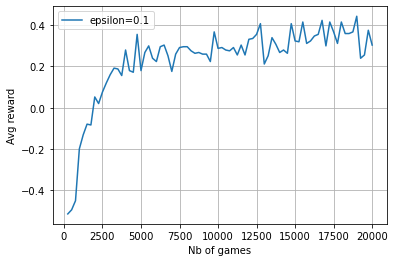

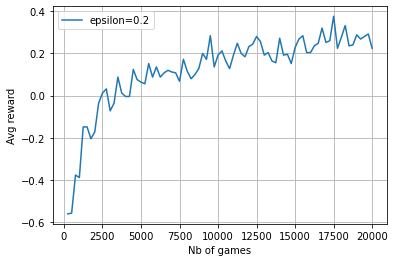

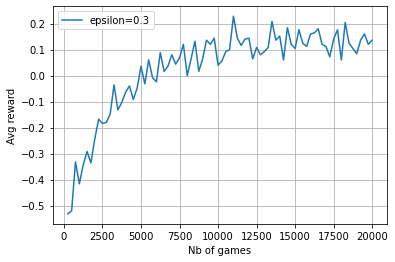

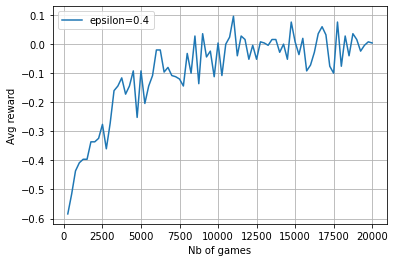

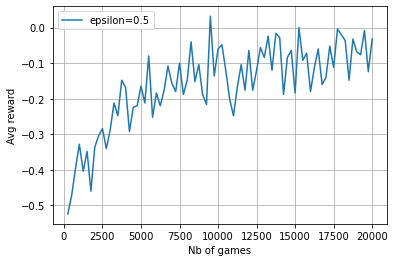

In [43]:
## Question 1
np.random.seed(2022)
random.seed(2023)
eps_vector = [0.1,0.2,0.3,0.4,0.5]
rew_epsilon = []

N = 20000
for epsilon in eps_vector:
    game = QLearning(epsilon,0.5)
    game.q_player.states_value = dict()
    game.play_n_games(N, epsilon*np.ones(N), eps_opponent_train = 0.5)
    game.plot_avg_reward(N,epsilon)
    rew_epsilon.append(game.reward_vec)
    print('epsilon=' + str(epsilon) + ' Mean reward: ' + str(np.mean(game.reward_vec)))

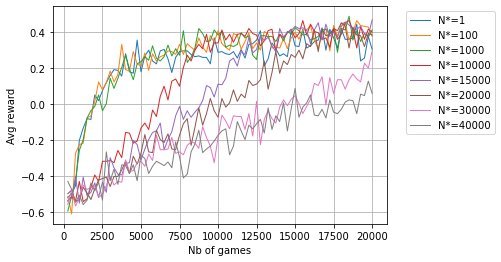

In [7]:
# Question 2
np.random.seed(2022)
random.seed(2023)
e_min = 0.1
e_max = 0.8
rew_N_star = []
N = 20000
N_star_vec = [1, 100, 1000, 10000, 15000, 20000, 30000,40000]
for N_star in N_star_vec :
    epsilon = []
    for i in np.arange(1,N+1):
        epsilon.append(max(e_min,e_max*(1-i/N_star)))
    game = QLearning(0,0.5)
    game.q_player.states_value = dict()
    game.play_n_games(N,epsilon)
    rew_N_star.append(game.reward_vec)
game.plot_N_star_reward(N_star_vec,N,rew_N_star)
    

N_star =1M_opt mean0.0
N_star =1M_rand mean0.8241025641025641
N_star =10M_opt mean0.0
N_star =10M_rand mean0.8177948717948716
N_star =100M_opt mean0.0
N_star =100M_rand mean0.9085128205128206
N_star =1000M_opt mean0.0
N_star =1000M_rand mean0.8429743589743591
N_star =10000M_opt mean0.0
N_star =10000M_rand mean0.8414358974358975
N_star =15000M_opt mean0.0
N_star =15000M_rand mean0.7959999999999999
N_star =20000M_opt mean0.0
N_star =20000M_rand mean0.7692307692307693
N_star =30000M_opt mean0.0
N_star =30000M_rand mean0.8142051282051281
N_star =40000M_opt mean0.0
N_star =40000M_rand mean0.7709743589743591


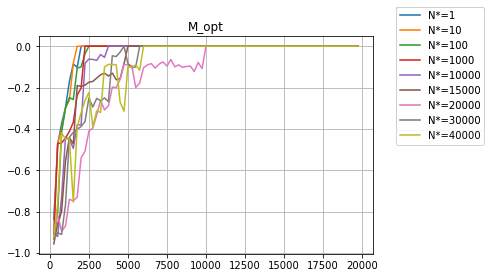

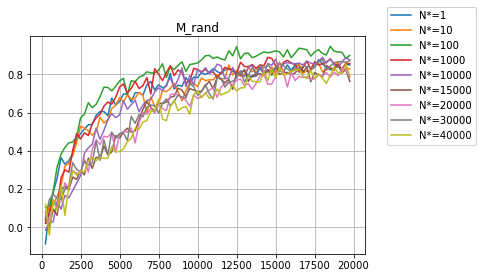

In [27]:
## Question 3
np.random.seed(2022)
random.seed(2023)
e_min = 0.1
e_max = 0.8
N = 20000
N_star_vec = [1,10,100, 1000, 10000, 15000, 20000, 30000,40000]
plt1, ax1 = plt.subplots()
plt2, ax2 = plt.subplots()
for N_star in N_star_vec :
    epsilon = []
    for i in np.arange(1,N+1):
        epsilon.append(max(e_min,e_max*(1-i/N_star)))
    game = QLearning(epsilon, 0.5)
    game.q_player.states_value = dict()
    M_opt_vec, M_rand_vec = game.play_train_test(epsilon, n_train = 250, n_tot_train = N, n_test = 500)
    print('N_star =' + str(N_star) + ' M_opt mean ' + str(np.mean(M_opt_vec[40:])))
    print('N_star =' + str(N_star) + ' M_rand mean ' + str(np.mean(M_rand_vec[40:])))
    ax1.plot(np.arange(1,len(M_opt_vec)+1)*250, M_opt_vec, label = 'N*='+str(N_star))
    ax1.set_title('M_opt')
    plt1.legend(bbox_to_anchor=(0.94,1), loc="upper left")
    ax1.grid()
    ax2.plot(np.arange(1,len(M_rand_vec)+1)*250, M_rand_vec, label = 'N*='+str(N_star))
    plt2.legend(bbox_to_anchor=(0.94,1), loc="upper left")
    ax2.grid()
    ax2.set_title('M_rand')

In [25]:
print(len(M_opt_vec))

79


epsilon =0 M_opt mean -0.001794871794871795
epsilon =0 M_rand mean 0.07707692307692308
epsilon =0.2 M_opt mean 0.0
epsilon =0.2 M_rand mean 0.5408205128205127
epsilon =0.4 M_opt mean 0.0
epsilon =0.4 M_rand mean 0.7221538461538461
epsilon =0.6 M_opt mean -0.002512820512820513
epsilon =0.6 M_rand mean 0.8563076923076921
epsilon =0.8 M_opt mean -0.0051794871794871794
epsilon =0.8 M_rand mean 0.8494358974358972
epsilon =1 M_opt mean -0.16723076923076927
epsilon =1 M_rand mean 0.8488205128205129


Text(0.5, 1.0, 'M_rand')

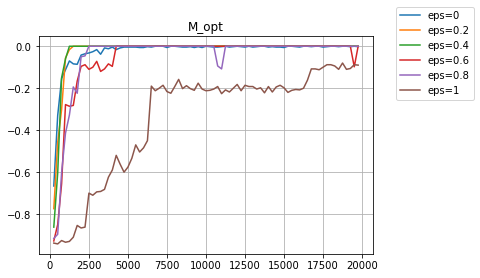

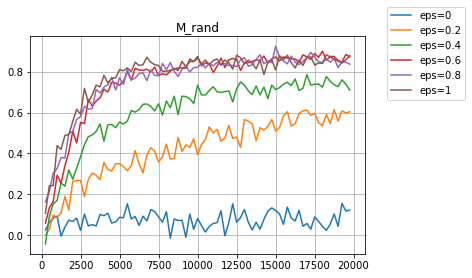

In [37]:
## Question 4
np.random.seed(2022)
random.seed(2022)
epsilon = []
e_min = 0.1
e_max = 0.8
N = 20000
N_star = 100

plt1, ax1 = plt.subplots()
plt2, ax2 = plt.subplots()

for i in np.arange(1,N+1):
    epsilon.append(max(e_min,e_max*(1-i/N_star)))
    
eps_opt = [0, 0.2, 0.4, 0.6, 0.8, 1]
for eps in eps_opt:
    game = QLearning(0, eps)
    game.q_player.states_value = dict()
    M_opt_vec, M_rand_vec = game.play_train_test(epsilon, eps_opponent_train = eps, n_train = 250, n_tot_train = N, n_test = 500)
    print('epsilon=' + str(eps) + ' M_opt mean ' + str(np.mean(M_opt_vec[40:])))
    print('epsilon=' + str(eps) + ' M_rand mean ' + str(np.mean(M_rand_vec[40:])))
    ax1.plot(np.arange(1,len(M_opt_vec)+1)*250, M_opt_vec, label = 'eps='+str(eps))
    ax2.plot(np.arange(1,len(M_rand_vec)+1)*250, M_rand_vec, label = 'eps='+str(eps))
       
plt1.legend(bbox_to_anchor=(0.94,1), loc="upper left")
ax1.grid()
ax1.set_title('M_opt')  
plt2.legend(bbox_to_anchor=(0.94,1), loc="upper left")
ax2.grid()
ax2.set_title('M_rand') 

In [38]:
class SelfQLearning:
    def __init__(self, epsilon1, epsilon2 = 0.5, alpha = 0.05, gamma = 0.99):
        self.q_player1 = QPlayer(epsilon1, alpha, gamma, player_name = 'O')
        self.q_player2 = QPlayer(epsilon1, alpha, gamma, player_name = 'X')
        self.opponent = OptimalPlayer(epsilon2)
        self.env = TictactoeEnv()
        self.reward_vec = []
        
    def game_train(self, eps_q_player):
        self.env.reset()
        
        states = []
        states.append(self.env.grid.copy())
        
        self.q_player1.epsilon = eps_q_player
        self.q_player2.epsilon = eps_q_player
        
        move1 = -1
        move2 = -1
        
        while not self.env.end : 
            if self.env.current_player == self.q_player1.player_name :   
                move1 = self.q_player1.act(states[-1])
                self.env.step(move1)
                    
            else : 

                move2 = self.q_player2.act(states[-1])
                self.env.step(move2)
                
            states.append(self.env.grid.copy())                    
                
            if self.env.current_player == self.q_player1.player_name and move1 != -1: 
                self.update_q(self.q_player1.player_name, states[-3], states[-1], move1)
            if self.env.current_player == self.q_player2.player_name and move2 != -1: 
                self.update_q(self.q_player2.player_name, states[-3], states[-1], move2)
                
        if self.env.end and self.env.current_player == self.q_player2.player_name :
            #print('Move1',move1)
            self.update_q(self.q_player1.player_name, states[-2], states[-1], move1)
        if self.env.end and self.env.current_player == self.q_player1.player_name :
            #print('Move2',move2)
            self.update_q(self.q_player2.player_name, states[-2], states[-1], move2)

                
        return self.env.reward(self.q_player1.player_name)
        
        
    def update_q(self, player_name, state_prec, state, move_q):
        """
        Function updating the table of Q-values
        INPUT:
        - player: id of the player
        - states: array with states visited by the agent
        - actions: array with actions performed by the agent
        """
        r = self.env.reward(player_name) # get the reward of the q_player 
        
        # the Q-values table of the terminal state is initialized with zeros
        if player_name == self.q_player1.player_name:
            key = self.q_player1.correct_grid(state)
            key_prec = self.q_player1.correct_grid(state_prec)
        else:
            key = self.q_player2.correct_grid(state)
            key_prec = self.q_player2.correct_grid(state_prec)

        # check if the state is already present 
        if key not in self.q_player1.states_value:
            self.q_player1.states_value[key] = np.zeros([9,1])
        if key_prec not in self.q_player1.states_value:
            self.q_player1.states_value[key_prec] = np.zeros([9,1])
            
        # update Q(s,a)
        self.q_player1.states_value[key_prec][move_q] += self.q_player1.alpha*(r + self.q_player1.gamma*max([self.q_player1.states_value[key][pos] for pos in self.q_player1.empty(state)], default=0)-self.q_player1.states_value[key_prec][move_q])  
       
    def game_test(self, eps_q_player, eps_opponent = 0):
        """
        Function to play a test game
        INPUTS:
        - eps_q_player: exploration level of q_player
        - eps_opponent: exploration level of opponent (default = 0.5)
        """
        self.env.reset() # reset the board
        #setting exploration levels
        self.q_player1.epsilon = eps_q_player
        self.opponent.epsilon = eps_opponent
        
        while not self.env.end: # while the game is not over
            
            if self.env.current_player == self.q_player1.player_name :
                # action of the q_player
                move_q = self.q_player1.act(self.env.grid)
                self.env.step(move_q)
            else:
                # action of the opponent
                move_opp = self.opponent.act(self.env.grid)
                self.env.step(move_opp)

        # return reward of the q-player
        return self.env.reward(self.q_player1.player_name)
            
    def play_n_games(self, n, epsilon, ntt = 0, get_reward = True):
        r = 0
        for i in range(n):
            self.q_player1.set_player('O',i)
            self.q_player2.set_player('X',i+1)
            r += self.game_train(epsilon[i+ntt])
            if (i+1)%250 == 0 and i != 0 and get_reward:
                self.reward_vec.append(r/250)
                r = 0
                
    def play_train_test(self, epsilon, n_train = 250, n_tot_train = 20000, n_test = 500):
        ntt = 0
        M_opt_vec = []
        M_rand_vec = []
        while ntt < n_tot_train:
            self.play_n_games(n_train, epsilon, ntt, False)
            if ntt!=0 and ntt%n_train == 0 :
                M_opt_vec.append(self.test(n_test,0))
                M_rand_vec.append(self.test(n_test,1))
            ntt += 250
            
        return M_opt_vec, M_rand_vec
    
    def test(self,n_test,epsilon):
        M = 0
        for i in range(n_test):
            self.q_player1.set_player('O',i)
            self.opponent.set_player('X',i)
            new_val = self.game_test(0, eps_opponent = epsilon)
            
            M += new_val
        return M/n_test
                
            
    def plot_avg_reward(self, n, epsilon, step=250):
        xx = np.arange(step,n+1,step)
        #print(xx)
        yy = self.reward_vec
        #print(yy)
        fig = plt.figure()
        plt.plot(xx,yy, label = "epsilon="+str(epsilon))
        plt.legend()
        plt.grid()
        plt.xlabel("Nb of games")
        plt.ylabel("Avg reward")
        #fig.savefig("ploteps_"+str(epsilon)+".png")
        
    def plot_N_star_reward(self,N_star, n, rewards, step = 250):
        xx = np.arange(step,n+1,step)
        fig = plt.figure()

        for i in range(len(N_star)):
            plt.plot(xx,rewards[i], label = 'N*='+str(N_star[i]))
            plt.legend()
            plt.xlabel("Nb of games")
            plt.ylabel("Avg reward")
            plt.grid()
        

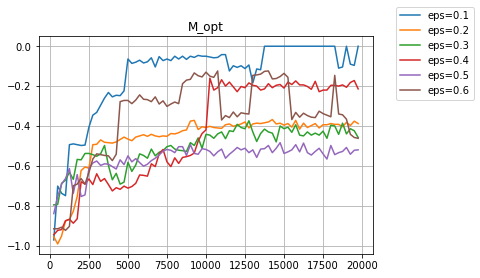

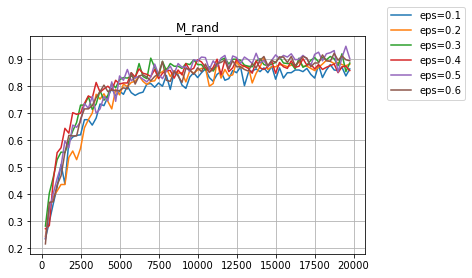

In [23]:
## Question 7
np.random.seed(2022)
random.seed(2023)
eps_vector = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
rew_epsilon = []


plt1, ax1 = plt.subplots()
plt2, ax2 = plt.subplots()

ax1.set_title('M_opt')
ax2.set_title('M_rand')

for epsilon in eps_vector:
    game = SelfQLearning(epsilon)
    game.q_player1.states_value = dict()
    M_opt_vec, M_rand_vec = game.play_train_test(epsilon*np.ones(20000), n_train = 250, n_tot_train = 20000, n_test = 500)
    ax1.plot(np.arange(1,len(M_opt_vec)+1)*250, M_opt_vec, label = 'eps='+str(epsilon))
    ax2.plot(np.arange(1,len(M_rand_vec)+1)*250, M_rand_vec, label = 'eps='+str(epsilon))

ax1.grid()
ax2.grid()

plt1.legend(bbox_to_anchor=(0.94,1), loc="upper left")
plt2.legend(bbox_to_anchor=(0.94,1), loc="upper left")


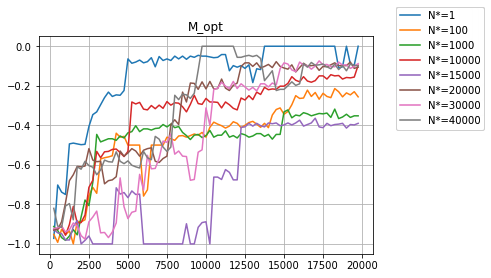

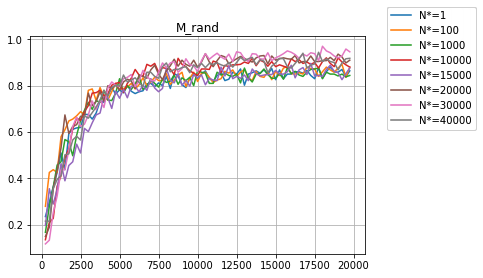

In [40]:
#Question 8
np.random.seed(2022)
random.seed(2023)

plt1, ax1 = plt.subplots()
plt2, ax2 = plt.subplots()

e_min = 0.1
e_max = 0.8
N = 20000
N_star_vec = [1, 100, 1000, 10000, 15000, 20000, 30000,40000] 

for N_star in N_star_vec :
    epsilon = []
    for i in np.arange(1,N+1):
        epsilon.append(max(e_min,e_max*(1-i/N_star)))
    game = SelfQLearning(epsilon)
    game.q_player1.states_value = dict()
    M_opt_vec, M_rand_vec = game.play_train_test(epsilon, n_train = 250, n_tot_train = N, n_test = 500)
    ax1.plot(np.arange(1,len(M_opt_vec)+1)*250, M_opt_vec, label = 'N*='+str(N_star))
    ax1.set_title('M_opt')
    plt1.legend(bbox_to_anchor=(0.94,1), loc="upper left")
    ax2.plot(np.arange(1,len(M_rand_vec)+1)*250, M_rand_vec, label = 'N*='+str(N_star))
    plt2.legend(bbox_to_anchor=(0.94,1), loc="upper left")
    ax2.set_title('M_rand')

ax1.grid()
ax2.grid()

plt1.legend(bbox_to_anchor=(0.94,1), loc="upper left")
plt2.legend(bbox_to_anchor=(0.94,1), loc="upper left")

In [13]:
game.q_player1.states_value

{'[-0. -0. -1. -0. -0. -0. -0. -0. -0.]': array([[0.02828646],
        [0.00973815],
        [0.        ],
        [0.02627976],
        [0.10936106],
        [0.01333707],
        [0.20822934],
        [0.03212111],
        [0.11330241]]),
 '[ 0.  0.  1.  0.  0.  0. -1.  0.  0.]': array([[0.10776643],
        [0.29270304],
        [0.        ],
        [0.01774036],
        [0.03461559],
        [0.09868733],
        [0.        ],
        [0.00937359],
        [0.12906055]]),
 '[0. 0. 0. 0. 0. 0. 0. 0. 0.]': array([[0.25638945],
        [0.71127478],
        [0.24747645],
        [0.19685193],
        [0.36818683],
        [0.18367952],
        [0.15970273],
        [0.20148839],
        [0.18353648]]),
 '[-1. -0. -1. -0. -0. -0.  1. -0. -0.]': array([[ 0.        ],
        [ 0.01471191],
        [ 0.        ],
        [-0.04659358],
        [-0.10091848],
        [-0.20228085],
        [ 0.        ],
        [-0.06673145],
        [-0.08007703]]),
 '[ 1.  0.  1.  0.  0.  0. -1. -1.  

<AxesSubplot:>

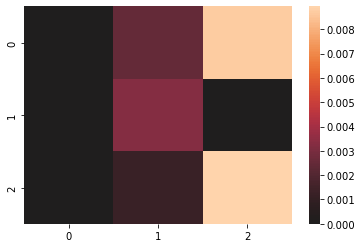

In [19]:
#Question 10
#states1 = game.q_player1.get_state_key(np.array([[0, 0., 1.], [0., 0., 1.], [-1., 0., 0.]]))
states1 = '[ 1.  0.  0. -1.  0.  1. -1.  0.  0.]'
sn.heatmap(game.q_player1.states_value[states1].reshape(3,3), center=0)


<AxesSubplot:>

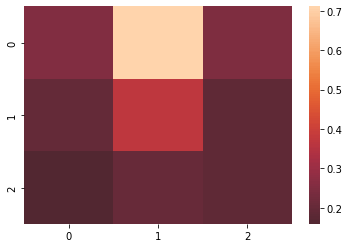

In [21]:
states2 = '[0. 0. 0. 0. 0. 0. 0. 0. 0.]'
sn.heatmap(game.q_player1.states_value[states2].reshape(3,3), center=0)

<AxesSubplot:>

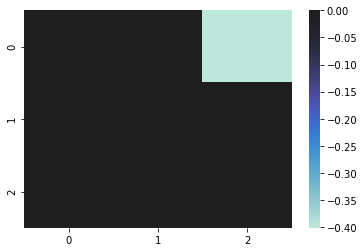

In [26]:
states3 = game.q_player1.get_state_key(np.array([[1, -1, 0.], [-1, -1, 1], [1, 1, 0.]]))
sn.heatmap(game.q_player1.states_value[states3].reshape(3,3), center=0)